# Exploratory Data Analysis

This feels a little out of order because I've already done some processing. But that was crucial to be able to look at the data further. With that done, I have a few EDA angles to take here.

1. Look for representation of each schema in my data, and how balanced that representation is.
2. Look at word frequency in my questions, see if anything looks out of whack.
3. Look at similarity between schema titles. I may not fix anything here, but want to know what challenges I may face in modelling, predicting.

## Imports & Data Loading

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
import pickle #for loading processed data

%matplotlib inline

In [32]:
with open('../data/processed/processed_training_data.pkl', 'rb') as pkl_file:
    training = pickle.load(pkl_file)

training.head()

,schema,question_proc
0,department_management,"[many, head, department, older, 56]"
1,department_management,"[list, name, bear, state, age, head, departmen..."
2,department_management,"[list, creation, year, name, budget, department]"
3,department_management,"[maximum, minimum, budget, department]"
4,department_management,"[average, number, employee, department, whose,..."


## Training Data EDA

### 1. Schema Representation

#### Bring in schema information to compare to training data

In [34]:
schema = pd.read_csv('../data/processed/schema_info.csv')
schema.head()

,schema,table,column_name,column_type,is_primary_key,is_foreign_key,fk_reference_table,fk_reference_column
0,perpetrator,perpetrator,perpetrator_id,numeric,True,False,NaN,NaN
1,perpetrator,perpetrator,people_id,numeric,False,True,people,People_ID
2,perpetrator,perpetrator,date_value,date,False,False,NaN,NaN
3,perpetrator,perpetrator,year,numeric,False,False,NaN,NaN
4,perpetrator,perpetrator,location,text,False,False,NaN,NaN


#### Compare schema in full schema info to schema in training data

In [35]:
#create unique lists of schemas from each source
schema_list = schema['schema'].unique().tolist()
training_list = training['schema'].unique().tolist()

In [36]:
#highlight missing values
missing_values = list(set(schema_list) - set(training_list))

print("These " +str(len(missing_values)) +" schemas are not represented:\n")
print(sorted(missing_values))

These 20 schemas are not represented:

['battle_death', 'car_1', 'concert_singer', 'course_teach', 'cre_Doc_Template_Mgt', 'dog_kennels', 'employee_hire_evaluation', 'flight_2', 'museum_visit', 'network_1', 'orchestra', 'pets_1', 'poker_player', 'real_estate_properties', 'singer', 'student_transcripts_tracking', 'tvshow', 'voter_1', 'world_1', 'wta_1']


In [37]:
#it's possible there may just be some lower vs. upper case issues on some of these? Let's confirm some items.

training.loc[training.schema.str.contains('flight')]['schema'].value_counts()

schema
flight_1          96
flight_4          82
flight_company    19
Name: count, dtype: int64

It really does look like these 20 schemas are missing. I wonder if these are just withheld completely for testing?

If we can't figure out if they are missing for a reason or just due to oversight we could benefit from writing some manual questions before we do a full pre-processing for training.


#### Decision - Write more questions or accept missing schemas

In [38]:
# Pull in test data to see if its represented (is this like seeing the bride before the wedding?)
path = '../data/raw/spider/'

with open(path+'dev.json', "r") as f:
    dev = json.load(f)

In [39]:
#create list of schemas represented
dev_schemas = []

for i in range(len(dev)):
    schem = dev[i]['db_id']
    dev_schemas.append(schem)

In [40]:
#return which values match between our missing in training and our test data
matching = list(set(missing_values) & set(dev_schemas))

print("These " +str(len(matching)) +" schemas are in the test data:\n")
print(sorted(matching))

These 20 schemas are in the test data:

['battle_death', 'car_1', 'concert_singer', 'course_teach', 'cre_Doc_Template_Mgt', 'dog_kennels', 'employee_hire_evaluation', 'flight_2', 'museum_visit', 'network_1', 'orchestra', 'pets_1', 'poker_player', 'real_estate_properties', 'singer', 'student_transcripts_tracking', 'tvshow', 'voter_1', 'world_1', 'wta_1']


They appear to be withheld on purpose. I'll keep moving on!

#### View Distribution of Schemas

Since there are so many, let's group everything that has less than 50 instances.

In [41]:
#set counts into dataframe
counts = training.schema.value_counts().rename_axis('schema').reset_index(name='counts')
counts.head()

,schema,counts
0,scholar,569
1,geo,564
2,academic,181
3,college_2,170
4,college_1,164


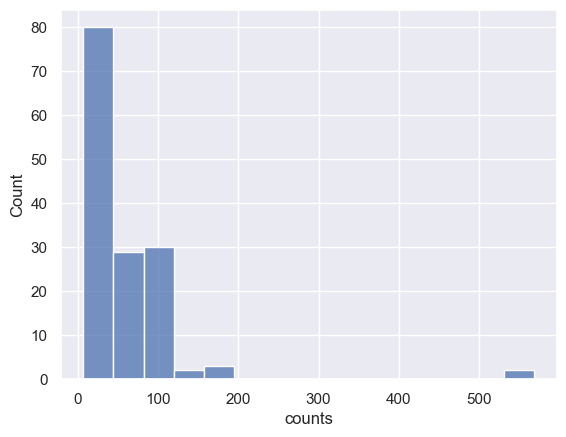

        schema  counts
0      scholar     569
1          geo     564
2     academic     181
3    college_2     170
4    college_1     164
5  restaurants     125
6         hr_1     124
7      store_1     112
8         yelp     111
9         imdb     109


In [46]:
#visualize histogram of schema representation (count)
sns.set(style="darkgrid")

sns.histplot(data=counts, x='counts', bins=15)
plt.show()

print(counts.head(10))

We are very heavy on the scholar and geo dataframes. These aren't part of the main spider data, but from other common datasources added to the project.

Apart from unbalanced classes, this isn't necessarily an issue. We could do a balancing step. But we could also drop these and focus on only the main spider database. I'll come back to that later.

### 2. Question Word Frequency